In [ ]:
pip install -U yellowbrick

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
#import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from datetime import datetime
from google.colab import files
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS # for MDS dimensionality reduction

from sklearn.mixture import GaussianMixture
from sklearn import metrics

In [ ]:
data=pd.read_csv('/content/data.csv',delimiter=';' ,decimal=",")

In [ ]:
df_ID=data['pseudonym']

In [ ]:
#upload normalised dataset
norm_df=pd.read_csv('/content/norm_data_final.csv',sep = '\,', header = 0, engine = 'python')

In [ ]:
norm_df.drop(['Unnamed: 0'],axis=1,inplace=True )

In [ ]:
#Find the highly correlated features.
#need to confirm weather these highly correlated features drop from data set
correlated_features = set() #use set data structure for avoid duplicates
correlation_matrix = norm_df.corr()
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(correlated_features)

{'Minimum_of_accelerometer_6mwt_split4_v2', 'Deviation_of_accelerometer_6mwt_split2_v3', 'Maximum_of_accelerometer_6mwt_split2_v2', 'Deviation_of_accelerometer_6mwt_split4_v1', 'Maximum_of_accelerometer_6mwt_split4_v1', 'Deviation_of_accelerometer_6mwt_split4_v2', 'Minimum_of_accelerometer_6mwt_split3_v2', 'Deviation_of_accelerometer_6mwt_split3_v3', 'Minimum_of_accelerometer_sct_split2_v3', 'Minimum_of_accelerometer_6mwt_split2_v3', 'Deviation_of_accelerometer_6mwt_split3_v2', 'Deviation_of_accelerometer_6mwt_split1_v3', 'Deviation_of_accelerometer_6mwt_split4_v3', 'Minimum_of_accelerometer_6mwt_split3_v1', 'amount_of_confidence_two_in_sct', 'Deviation_of_accelerometer_6mwt_split2_v1', 'Deviation_of_accelerometer_6mwt_split2_v2', 'Deviation_of_smartphone_6mwt', 'panas_neg_t4', 'Minimum_of_accelerometer_6mwt_split4_v3', 'Maximum_of_accelerometer_6mwt_split3_v2', 'Deviation_of_accelerometer_6mwt_split3_v1', 'Deviation_of_smartphone_sct', 'Minimum_of_accelerometer_6mwt_split3_v3', 'Maxim

In [ ]:
print(len(correlated_features))

26


In [ ]:
#drop highly correlated data
norm_df.drop(['Deviation_of_accelerometer_6mwt_split4_v1', 'Minimum_of_accelerometer_6mwt_split4_v3', 'Minimum_of_accelerometer_6mwt_split3_v2', 'Minimum_of_accelerometer_6mwt_split3_v3', 'Minimum_of_accelerometer_sct_split2_v3', 'Maximum_of_accelerometer_6mwt_split4_v3', 'Deviation_of_smartphone_sct', 'amount_of_confidence_two_in_sct', 'Deviation_of_accelerometer_6mwt_split2_v1', 'Deviation_of_accelerometer_6mwt_split2_v2', 'panas_neg_t4', 'Deviation_of_accelerometer_6mwt_split1_v3', 'Deviation_of_accelerometer_6mwt_split4_v2', 'hee_t4', 'Maximum_of_accelerometer_6mwt_split4_v1', 'Deviation_of_accelerometer_6mwt_split3_v3', 'Deviation_of_accelerometer_6mwt_split3_v2', 'Minimum_of_accelerometer_6mwt_split4_v2', 'Deviation_of_smartphone_6mwt', 'Deviation_of_accelerometer_6mwt_split3_v1', 'Deviation_of_accelerometer_6mwt_split4_v3', 'Maximum_of_accelerometer_6mwt_split3_v2', 'Deviation_of_accelerometer_6mwt_split2_v3', 'Maximum_of_accelerometer_6mwt_split2_v2', 'Minimum_of_accelerometer_6mwt_split2_v3', 'Minimum_of_accelerometer_6mwt_split3_v1'],axis=1,inplace=True)

**Dimensionality reduction : ISOMAP**

In [ ]:
#Isomap: non-linear dimensionality reduction
from sklearn import manifold

df_isomap_cpy = norm_df.copy()
iso = manifold.Isomap(n_neighbors=5, n_components=2)
iso.fit(df_isomap_cpy)
manifold_2Da = iso.transform(df_isomap_cpy)
mani_df = pd.DataFrame(manifold_2Da, columns=['c1', 'c2'])
np.random.seed(0)

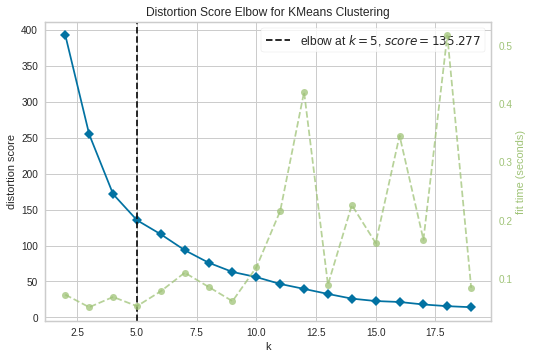

In [ ]:
#find optimal value for K for kmeans clustering
kmeans_model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans_model, k=(2,20), timings= True)
visualizer.fit(mani_df)        # Fit data to visualizer
visualizer.show() 

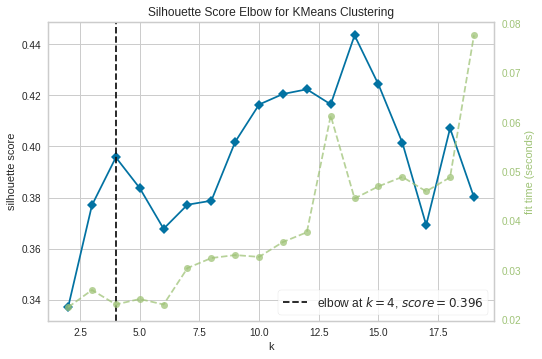

In [ ]:
# Silhouette Score for K means
# Import ElbowVisualizer
#from yellowbrick.cluster import KElbowVisualizer
mod1 = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(mod1, k=(2,20),metric='silhouette', timings= True)
visualizer.fit(mani_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

1

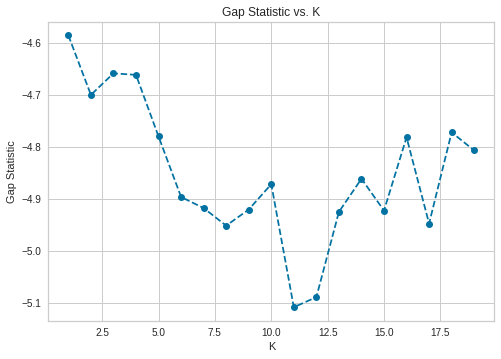

In [ ]:
def optimalK(data, nrefs=3, maxClusters=20):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
# Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
# Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
# Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
# Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)
score_g, df = optimalK(mani_df, nrefs=3, maxClusters=20)

plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');
score_g
#all negative, it means Gap Statistic cannot define k, k=1

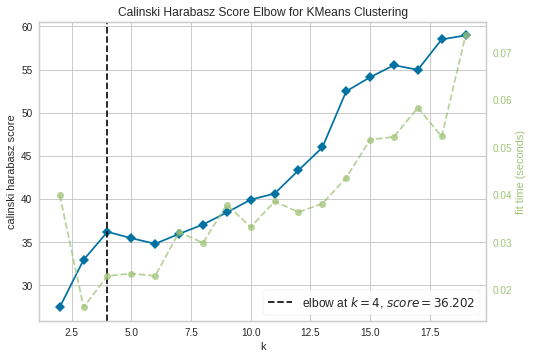

In [ ]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
#from yellowbrick.cluster import KElbowVisualizer
mod2 = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(mod2, k=(2,20),metric='calinski_harabasz', timings= True)
visualizer.fit(mani_df)        # Fit the data to the visualizer
visualizer.show()

In [ ]:
#k=4
#Apply Kmeans clustering algorithm
kmeans = KMeans(4)
#Apply kMeans on data
kmeans.fit(mani_df)
labels = kmeans.labels_ #label/ cluster associating to each data points
#this is centroid of all clusters
kmeans.cluster_centers_.shape
#create a data frame having kmeans centroid and col of df1
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [mani_df.columns])
#cluster_centers
y_kmeans = kmeans.fit_predict(mani_df)
#y_kmeans

In [ ]:
# concatenate the clusters labels to our original dataframe(orignal_cleaned_data)
orignal_cleaned_data=pd.read_csv('/content/norm_data_final.csv')
orignal_cleaned_data.drop(['Unnamed: 0'],axis=1,inplace=True)
df_cluster = pd.concat([orignal_cleaned_data, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster.head()

,ageGroup,gender,smoker,employed,sports,timeOfDay,testSuit,firstTask,arrival_car/motorcycle,arrival_on foot,...,Minimum_of_accelerometer_sct_split1_v3,Deviation_of_accerometer_sct_split1_V3,Maximum_of_accelerometer_sct_split2_v3,Minimum_of_accelerometer_sct_split2_v3,Deviation_of_accerometer_sct_split2_V3,swe_6mwtask_after,swe_6mwtask_before,swe_sctask_after,swe_sctask_before,cluster
0,1,0,0,1,1,1,0,1,0,0,...,0.913079,0.138895,0.144737,0.863489,0.125912,0.928571,0.947368,0.684211,0.818182,1
1,0,1,0,1,0,0,1,0,0,1,...,0.778229,0.254278,0.137218,0.713976,0.335416,1.000000,0.526316,1.000000,0.772727,1
2,0,0,0,1,1,0,1,1,1,0,...,0.809098,0.212939,0.084586,0.561213,0.364674,1.000000,0.947368,1.000000,0.818182,0
3,1,1,0,1,1,0,1,0,0,0,...,0.914703,0.168966,0.144737,0.789816,0.270333,0.714286,0.894737,0.368421,1.000000,0
4,1,1,0,0,1,1,0,1,1,0,...,0.855402,0.165444,0.110902,0.612134,0.288120,1.000000,0.842105,0.263158,0.000000,1


In [ ]:
#Correlation check
corr_table = df_cluster.corr(method='pearson')
pd.set_option('display.max_rows', None, 'display.max_columns', None)
corr_table[abs(corr_table) > 0.5]['cluster']

ageGroup                                     NaN
gender                                       NaN
smoker                                       NaN
employed                                     NaN
sports                                       NaN
timeOfDay                                    NaN
testSuit                                     NaN
firstTask                                    NaN
arrival_car/motorcycle                       NaN
arrival_on foot                              NaN
arrival_public transport                     NaN
bmi                                          NaN
dist_6mwt                                    NaN
dist_sct                                     NaN
swe_b_t1                                     NaN
swe_b_t4                                     NaN
swe_m_t1                                     NaN
swe_m_t4                                     NaN
swe_f_t1                                     NaN
swe_f_t4                                     NaN
swe_a_t1            

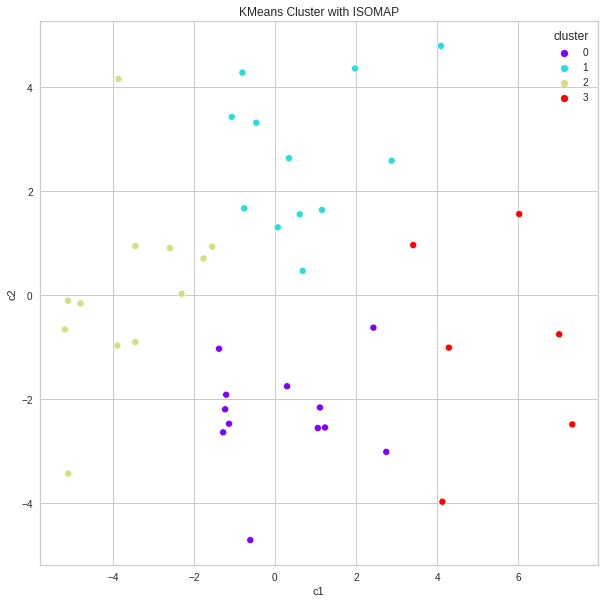

In [ ]:
# Concatenate the clusters labels to the dataframe(mani_df)
df_mani_kmeans=pd.concat([mani_df,pd.DataFrame({'cluster':labels})], axis = 1)
#visualize the clusters using isomap components
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="c1", y="c2", hue = "cluster", data = df_mani_kmeans, palette ='rainbow')
plt.title('KMeans Cluster with ISOMAP');
plt.show()

In [ ]:
# concatenate the clusters labels to participantsID dataset(df_ID)
df_id_cluster = pd.concat([df_ID, pd.DataFrame({'cluster_ISOMAP_KMeans':labels})], axis = 1)

**Apply HAC Algorithm**

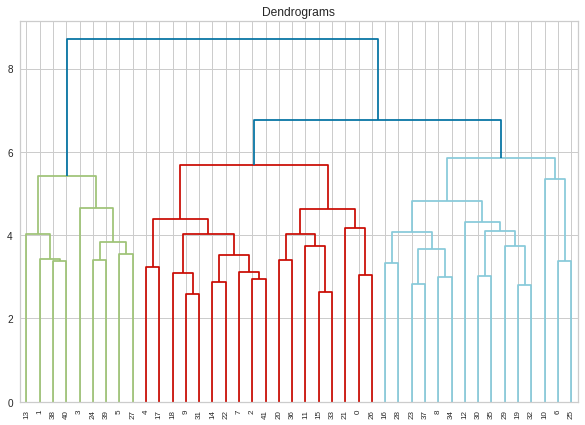

In [ ]:
#implement heirarchical clustering. Use original_cleaned_data
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(norm_df, method='ward'))

In [ ]:
#based on colour , we can decide optimal number of cluster. Or draw a horizontal line over blue line find count of intercet points
optimal_num_clusters=len(set(dend['color_list']))-1
print(optimal_num_clusters)

3


In [ ]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
y_hc=cluster.fit_predict(mani_df)
#0 represents the points that belong to the first cluster and 1 represents points in the second cluster, etc

In [ ]:
# Concatenate the clusters labels to the dataframe(pca_df)
df_mani_cpy=mani_df.copy()
df_mani_hac = pd.concat([df_mani_cpy,pd.DataFrame({'cluster_hac':y_hc})], axis = 1)

In [ ]:
df_mani_hac.head()

,c1,c2,cluster_hac
0,-0.757547,1.667743,1
1,4.095554,4.791032,1
2,0.299572,-1.756647,0
3,2.429635,-0.629155,2
4,1.159882,1.635852,1


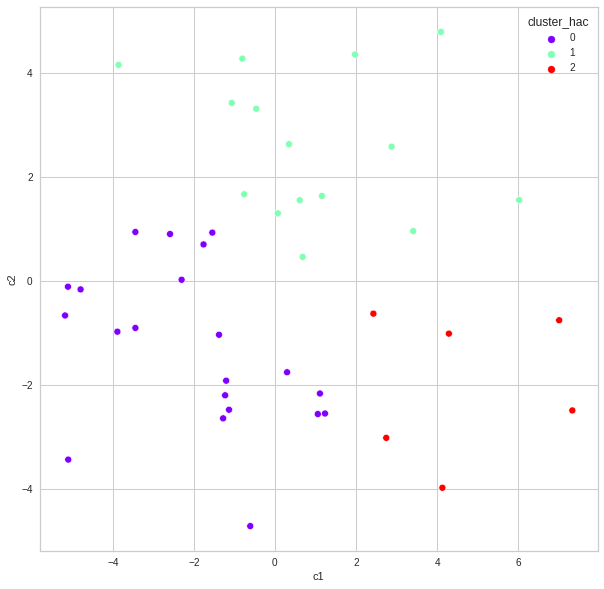

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="c1", y="c2", hue = "cluster_hac", data = df_mani_hac, palette ='rainbow')
plt.show()

In [ ]:
# concatenate the clusters labels to our original dataframe(orignal_cleaned_data)
orignal_cleaned_data=pd.read_csv('/content/norm_data_final.csv')
orignal_cleaned_data.drop(['Unnamed: 0'],axis=1,inplace=True)
df_cluster = pd.concat([orignal_cleaned_data, pd.DataFrame({'cluster_hac':y_hc})], axis = 1)
df_cluster.head()

#Correlation check
corr_table = df_cluster.corr(method='pearson')
pd.set_option('display.max_rows', None, 'display.max_columns', None)
corr_table[abs(corr_table) > 0.5]['cluster_hac']

ageGroup                                          NaN
gender                                            NaN
smoker                                            NaN
employed                                          NaN
sports                                            NaN
timeOfDay                                         NaN
testSuit                                          NaN
firstTask                                         NaN
arrival_car/motorcycle                            NaN
arrival_on foot                                   NaN
arrival_public transport                          NaN
bmi                                               NaN
dist_6mwt                                         NaN
dist_sct                                          NaN
swe_b_t1                                          NaN
swe_b_t4                                          NaN
swe_m_t1                                          NaN
swe_m_t4                                          NaN
swe_f_t1                    

**Apply DBSCAN Algorithm**

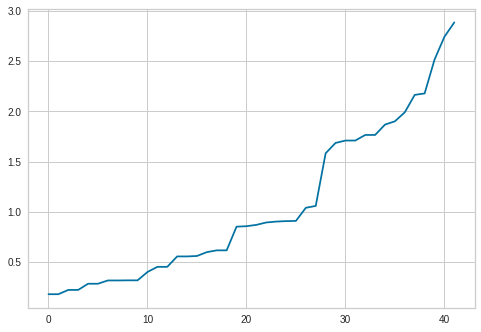

In [ ]:
#DBSCAN, let's find appropriate epsilon:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_mani_cpy)
distances, indices = nbrs.kneighbors(df_mani_cpy)
#print(distances)
distances = np.sort(distances, axis=0)
#print('.........................')
#print(distances)
distances = distances[:,1]
plt.plot(distances)

Text(0.5, 1.0, 'DBSCAN on ISOMAP')

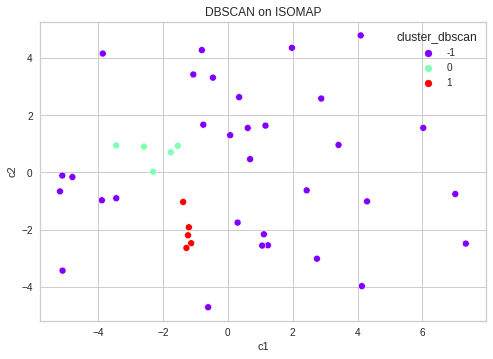

In [ ]:
db = DBSCAN(eps=1.1, min_samples=5).fit(df_mani_cpy)
y_dbscan=db.labels_
df_mani_dbscan = pd.concat([df_mani_cpy,pd.DataFrame({'cluster_dbscan':y_dbscan})], axis = 1)
a = sns.scatterplot(x='c1', y='c2', hue = 'cluster_dbscan', data = df_mani_dbscan, palette = 'rainbow')
a.set_title('DBSCAN on ISOMAP')

In [ ]:
# concatenate the clusters labels to our original dataframe(orignal_cleaned_data)
orignal_cleaned_data=pd.read_csv('/content/norm_data_final.csv')
orignal_cleaned_data.drop(['Unnamed: 0'],axis=1,inplace=True)
df_cluster = pd.concat([orignal_cleaned_data, pd.DataFrame({'cluster_dbscan':y_dbscan})], axis = 1)
df_cluster.head()

#Correlation check
corr_table = df_cluster.corr(method='pearson')
pd.set_option('display.max_rows', None, 'display.max_columns', None)
corr_table[abs(corr_table) > 0.5]['cluster_dbscan']

ageGroup                                     NaN
gender                                       NaN
smoker                                       NaN
employed                                     NaN
sports                                       NaN
timeOfDay                                    NaN
testSuit                                     NaN
firstTask                                    NaN
arrival_car/motorcycle                       NaN
arrival_on foot                              NaN
arrival_public transport                     NaN
bmi                                          NaN
dist_6mwt                                    NaN
dist_sct                                     NaN
swe_b_t1                                     NaN
swe_b_t4                                     NaN
swe_m_t1                                     NaN
swe_m_t4                                     NaN
swe_f_t1                                     NaN
swe_f_t4                                     NaN
swe_a_t1            

**Apply Gaussian misture clustering**

In [ ]:
#Gaussian misture, let's choose the proper number of clusters:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
for i in range(2, 11):
    gmm = GaussianMixture(n_components=i).fit(df_mani_cpy)
    df_mani_cpy['Cluster'] = gmm.predict(df_mani_cpy)
    d = metrics.silhouette_score(df_mani_cpy, df_mani_cpy['Cluster'], metric='euclidean')
    print(i, d)

2 0.3593302580268797
3 0.215472060998231
4 0.1734167323436561
5 0.10784132830605708
6 0.3260353379272902
7 0.48801334883480674
8 0.45490251212485705
9 0.49139354913839756
10 0.5280434527362663


Text(0.5, 1.0, 'Gaussian mixture on ISOMAP')

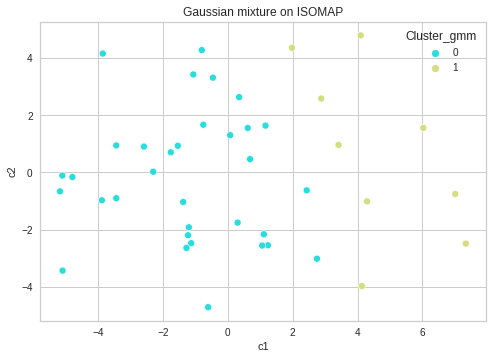

In [ ]:
df_mani_cpy.drop(['Cluster'], axis = 1,inplace=True)
gmm = GaussianMixture(n_components=2)
gmm.fit(df_mani_cpy)
df_mani_cpy['Cluster_gmm'] = gmm.predict(df_mani_cpy)
ax = sns.scatterplot(x='c1', y='c2', hue = 'Cluster_gmm', data = df_mani_cpy, palette = 'rainbow')
ax.set_title('Gaussian mixture on ISOMAP')

In [ ]:
df_mani_cpy.head()

,c1,c2,Cluster_gmm
0,-0.757547,1.667743,0
1,4.095554,4.791032,1
2,0.299572,-1.756647,0
3,2.429635,-0.629155,0
4,1.159882,1.635852,0


In [ ]:
# concatenate the clusters labels to our original dataframe(orignal_cleaned_data)
orignal_cleaned_data=pd.read_csv('/content/norm_data_final.csv')
orignal_cleaned_data.drop(['Unnamed: 0'],axis=1,inplace=True)
df_cluster = pd.concat([orignal_cleaned_data, df_mani_cpy['Cluster_gmm']], axis = 1)
df_cluster.head()

#Correlation check
corr_table = df_cluster.corr(method='pearson')
pd.set_option('display.max_rows', None, 'display.max_columns', None)
corr_table[abs(corr_table) > 0.5]['Cluster_gmm']


ageGroup                                          NaN
gender                                            NaN
smoker                                            NaN
employed                                          NaN
sports                                            NaN
timeOfDay                                         NaN
testSuit                                          NaN
firstTask                                         NaN
arrival_car/motorcycle                            NaN
arrival_on foot                                   NaN
arrival_public transport                          NaN
bmi                                               NaN
dist_6mwt                                         NaN
dist_sct                                          NaN
swe_b_t1                                    -0.577906
swe_b_t4                                    -0.671047
swe_m_t1                                    -0.501209
swe_m_t4                                          NaN
swe_f_t1                    

In [ ]:
cluster_assigned= pd.concat([df_ID,pd.DataFrame({'cluster_ISOMAP_KMeans':labels}),
                             pd.DataFrame({'cluster_ISOMAP_HAC':y_hc}),
                             pd.DataFrame({'cluster_ISOMAP_DBSCAN':y_dbscan}), 
                             pd.DataFrame({'cluster_ISOMAP_GMM':df_mani_cpy['Cluster_gmm']})], axis = 1)

In [ ]:
cluster_assigned

,pseudonym,cluster_ISOMAP_KMeans,cluster_ISOMAP_HAC,cluster_ISOMAP_DBSCAN,cluster_ISOMAP_GMM
0,0577770a,1,1,-1,0
1,10e5b7cd,1,1,-1,1
2,14103f09,0,0,-1,0
3,1d5d73b7,0,2,-1,0
4,2319ac8d,1,1,-1,0
5,2a8310f7,3,2,-1,1
6,2ac72c3c,2,0,-1,0
7,2b9ffa95,0,0,1,0
8,32548257,2,0,-1,0
9,458409e7,0,0,-1,0


In [ ]:
cluster_assigned.to_csv('cluster_assigned_isomap.csv')
files.download('cluster_assigned_isomap.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>